In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
LCZ_COLORS = {
    '1': '#8C0000',
    '2': '#D10000',
    '3': '#FF0000',
    '4': '#BF4D00',
    '5': '#FF6600',
    '6': '#FF9955',
    '7': '#FAEE05',
    '8': '#BCBCBC',
    '9': '#FFCCAA',
    '10': '#555555',
    '11': '#006A00',
    '12': '#00AA00',
    '13': '#648525',
    '14': '#B9DB79',
    '15': '#000000',
    '16': '#FBF7AE',
    '17': '#6A6AFF',
}

In [3]:
def make_data(n_range: tuple[int, int] = (3, 30), classes: list[int] | None = None):
    if not classes:
        classes = list(range(1, 18))

    data = []
    for c in classes:
        data.extend([c] * np.random.randint(*n_range))
    return data

In [4]:
def make_data_stratified(data: list[int]) -> pd.DataFrame:
    df = pd.DataFrame({'class': data})
    df = df.sort_values('class')

    for seed in range(1, 26):
        _, ta_test = train_test_split(
            df,
            # stratify this per LCZ-class so each class is split 30/70
            stratify=df['class'],
            test_size=0.2,
            random_state=seed,
        )
        # mark train as 1
        df[seed] = 'train'
        # ...and test as 0
        df.loc[ta_test.index, seed] = 'test'

    df = df.reset_index()
    df = df.melt(id_vars=['class', 'index'])
    df.groupby('variable')['index'].count()
    df = df.rename(columns={'variable': 'seed', 'value': 'test_train'})
    df['LCZ Class'] = 'LCZ Class'
    return df


In [5]:
def make_data_uniform(data: list[int]) -> pd.DataFrame:
    df = pd.DataFrame({'class': data})
    # set the numpy seed
    for seed in range(1, 26):
        np.random.seed(seed)
        mask = np.random.uniform(0, 1, len(df)) < 0.7
        df.loc[:, seed] = 'test'
        df.loc[mask, seed] = 'train'


    df = df.reset_index()
    df = df.melt(id_vars=['class', 'index'])
    df.groupby('variable')['index'].count()
    df = df.rename(columns={'variable': 'seed', 'value': 'test_train'})
    df['LCZ Class'] = 'LCZ Class'
    return df

In [6]:
def plot(data, *args, **kwargs):
    # get max index per class
    tick_labels = data.groupby('class').max()['index']
    data = data.sort_values('class')
    data.loc[: , 'class_str'] = data['class'].astype(str)
    data.reset_index(drop=True, inplace=True)
    # fig, ax = plt.subplots()
    ax = kwargs.get('ax')
    if not ax:
        ax = plt.gca()
    sns.scatterplot(data=data, x=data['index'], y='seed', hue='test_train', ax=ax, marker="_", lw=10, s=len(data)/ 30)
    sns.scatterplot(data=data, x=data['index'], y=0, hue='class_str', ax=ax, marker="_", lw=10, s=50, palette=LCZ_COLORS, legend=False)
    plt.tight_layout()
    ax.legend()
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Split (seed)')
    ax.xaxis.set_ticks(tick_labels)
    ax.set_xlim(-0.5, data['index'].max() + 0.5)
    ax.set_ylim(-0.55, 25.55)
    ax.grid(axis='x', color='black', lw=1)

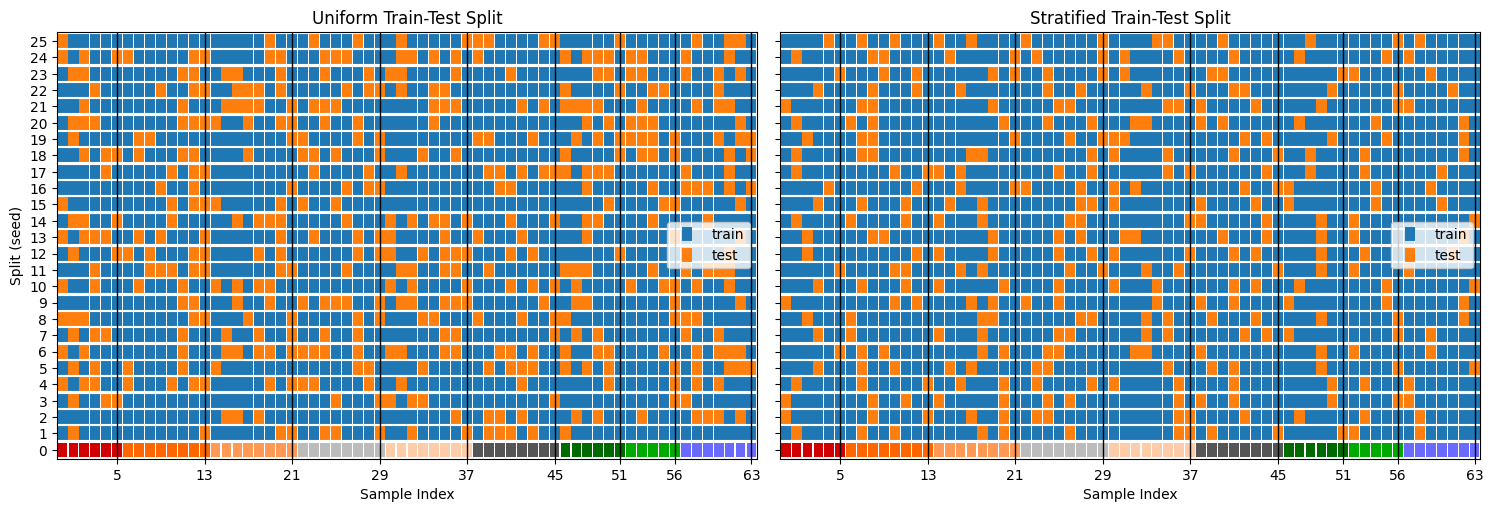

In [8]:
data_out = make_data(n_range=(3, 9), classes=[2, 5, 6, 8, 9, 10, 11, 12, 17])
# before = make_data_uniform(data)
# after = make_data_stratified(data)
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plot(make_data_uniform(data_out), ax=ax[0])
plot(make_data_stratified(data_out), ax=ax[1])
ax[0].set_title('Uniform Train-Test Split')
ax[1].set_title('Stratified Train-Test Split')
plt.savefig('train_test_split.png', dpi=300, bbox_inches='tight')
